In [17]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.metrics.scorer import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
import time

In [5]:
data = np.load('input_arrays.npy')

In [6]:
def data_subset(data):
    data_sub = []
    n = 103
    for i in range(10):
        digit_indices = np.argwhere(data[:,0] == i)
        random.shuffle(digit_indices)
        x = np.take(data, digit_indices[0:n], axis=0)[:,0,:]
        data_sub.append(x)
    
    x = np.array(data_sub).reshape((n*10,257))
    return x

data_sub = data_subset(data)
np.random.shuffle(data_sub)

In [7]:
class Forgetron(object):
    
    def __init__(self, batch_size, kerntype='poly', kerndegree=5, N=30, C=10):
        self.kernfunc = getattr(self, '_kern_'+kerntype)
        self.kerndegree = kerndegree
        self.S = [[] for _ in range(C)]
        self.alpha = np.zeros(shape=(C, batch_size))
        self.batch_size = batch_size
        self.distances = [[] for _ in range(C)]
        self.total_budget = 0
        self.C = C
        self.N = N
        
    def _kern_poly(self, x_i, x_t):
        return np.dot(x_i, x_t)**self.kerndegree
        
    def my_sign(self, x):
        if(x <= 0.0):
            return -1.0
        else:
            return 1.0
    
    def scores(self, S, alpha, x_train, x_):
        
        y_predict = np.zeros(self.C)
        
        for cl in range(self.C):
            
            cl_length = len(S[cl])
            
            for i in range(cl_length):
                index = self.S[cl][i]
                y_predict[cl] += alpha[cl,index]*self.kernfunc(x_train[index], x_)
    
        return y_predict
    
    def train_generation(self, x_train, y_train):
        
        mistakes = 0
        for i in range(self.batch_size):
            y_ = y_train[i,:]
            x_ = x_train[i,:]
            y_predict = self.scores(self.S, self.alpha, x_train, x_)
            
            for cl in range(self.C):
                
                if(y_ == cl):
                    y_label = 1.0
                else:
                    y_label = -1.0
                
                if(y_label*y_predict[cl] <= 0):
                    
                    self.alpha[cl, i] = self.alpha[cl, i] - self.my_sign(y_predict[cl])
                    
                    self.S[cl].append(i)
                    
                    self.total_budget += 1
                    
                    self.distances[cl].append(y_label*(y_predict[cl] - self.alpha[cl, i]*self.kernfunc(x_, x_)))
                    #print(y_label*(y_predict[cl] - self.alpha[cl, i]*self.kernfunc(x_, x_)))

            while(self.total_budget > self.N):
                
                arg_max_values = np.zeros(10)
                arg_max_indices = np.zeros(10)
                i = 0
                for cl in self.distances:
                    arg_max_index = 0
                    max_value = -np.inf
                    
                    if(len(cl) > 0):
                        arg_max_index = np.argmax(cl)
                        max_value = cl[arg_max_index]
                        
                    arg_max_values[i] = max_value
                    arg_max_indices[i] = arg_max_index
                    i += 1
                
                label = np.argmax(arg_max_values)
                del self.distances[label][int(arg_max_indices[label])]
                del self.S[label][int(arg_max_indices[label])] 
                
                self.total_budget -= 1
                
   
            if(np.argmax(y_predict) != y_):
                mistakes += 1
                
        return mistakes/self.batch_size
    
    def test_generation(self, x_train, x_test, y_test):
        mistakes = 0
        n = np.size(y_test)
        for i in range(n):
            y_ = y_test[i,:]
            x_ = x_test[i,:]
      
            y_predict = self.scores(self.S, self.alpha, x_train, x_)

            if(np.argmax(y_predict) != y_):
                mistakes += 1
            
        return mistakes/n

In [8]:
def run_k_epochs(x_train, y_train, x_test, y_test, number_of_epochs, d, budget):
    
    size = x_train.shape[0]
    cper = Forgetron(size, 'poly', d, budget, 10)
    m_1, m_2 = 0, 0
    
    for ep in range(number_of_epochs):
        print('Performing epoch {}...'.format(ep+1))
        
        m_1 = cper.train_generation(x_train, y_train)
        print('Percentage training error: {0:.2f}%'.format(100*m_1))
        m_2 = cper.test_generation(x_train, x_test, y_test)
        print('Percentage test error: {0:.2f}%\n'.format(100*m_2))

    return m_1, m_2 

In [34]:
def find_training_test_errors(data, budget):
    
    data_frame = {'d = ': [], 'Training error':[],
        'Test error':[],
       }
    df = pd.DataFrame(data_frame)

    n, dim = data.shape
    split_size = int(0.8*n)
    n_runs = 5
    errors = []
    for d in range(5, 8):
        training_errors = np.zeros(n_runs)
        test_errors = np.zeros(n_runs)
        print('Training for Polynomial Degree: {}'.format(d))
        
        for r in range(n_runs):
            print('------- Run {} -------'.format(r+1))
            np.random.shuffle(data)
            x_train = data[:split_size,1:dim]
            y_train = data[:split_size,0][:, np.newaxis]
            x_test = data[split_size:,1:dim]
            y_test = data[split_size:,0][:, np.newaxis]
            start = time.time()
            training_errors[r], test_errors[r] = run_k_epochs(x_train, y_train, x_test, y_test, 2, d, budget)
            end = time.time()
            print(end - start)
        errors.append(np.mean(test_errors))
        str0 = str(d)
        str1 = '{0:.2f}% \u00B1 {1:.2f}%'.format(100*np.mean(training_errors), 100*np.sqrt(np.var(training_errors)))
        str2 = '{0:.2f}% \u00B1 {1:.2f}%'.format(100*np.mean(test_errors), 100*np.sqrt(np.var(test_errors)))
        df = df.append({'d = ': d,'Training error': str1, 'Test error': str2}, ignore_index=True)
          
    df.index = np.arange(1,len(df)+1)
    return df, errors

In [35]:
def errors_with_budget(data_sub):
    errors_per_budget = []
    dfs = []
    for budget in [200, 275, 350, 425, 500]:
        df, errors = find_training_test_errors(data_sub, budget)
        errors_per_budget.append(errors)
        dfs.append(df)
    return errors_per_budget, dfs
        
        

In [36]:
errors_per_budget, dfs = errors_with_budget(data_sub)

Training for Polynomial Degree: 5
------- Run 1 -------
Performing epoch 1...
Percentage training error: 14.20%
Percentage test error: 2.43%

Performing epoch 2...
Percentage training error: 1.82%
Percentage test error: 5.34%

4.094146013259888
------- Run 2 -------
Performing epoch 1...
Percentage training error: 12.99%
Percentage test error: 7.77%

Performing epoch 2...
Percentage training error: 0.73%
Percentage test error: 3.88%

4.2715654373168945
------- Run 3 -------
Performing epoch 1...
Percentage training error: 13.11%
Percentage test error: 2.43%

Performing epoch 2...
Percentage training error: 1.58%
Percentage test error: 6.31%

4.342398643493652
------- Run 4 -------
Performing epoch 1...
Percentage training error: 12.99%
Percentage test error: 3.40%

Performing epoch 2...
Percentage training error: 1.94%
Percentage test error: 4.37%

4.354556083679199
------- Run 5 -------
Performing epoch 1...
Percentage training error: 12.26%
Percentage test error: 1.46%

Performing ep

KeyboardInterrupt: 

In [2]:
display(dfs[0], dfs[1], dfs[2], dfs[3], dfs[4])

NameError: name 'dfs' is not defined

In [30]:
e = np.array(errors_per_budget)

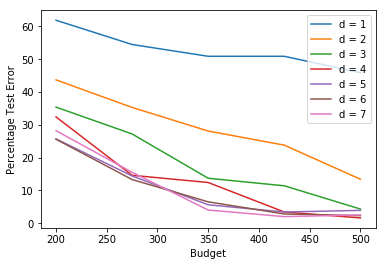

In [53]:
range_ = np.array([200,275,350,425,500])
for d in range(7):
    line = e[:,d]*100
    plt.plot(range_, line, label='d = {}'.format(d+1))
    plt.legend()
    plt.ylabel('Percentage Test Error')
    plt.xlabel('Budget')

In [56]:
errors_per_budget_2, dfs_2 = errors_with_budget(data_sub)

Training for Polynomial Degree: 1
------- Run 1 -------
Performing epoch 1...
Percentage training error: 27.00%
Percentage test error: 10.00%

Performing epoch 2...
Percentage training error: 19.62%
Percentage test error: 11.50%

Performing epoch 3...
Percentage training error: 21.25%
Percentage test error: 19.00%

Performing epoch 4...
Percentage training error: 24.25%
Percentage test error: 24.50%

Performing epoch 5...
Percentage training error: 21.88%
Percentage test error: 17.50%

------- Run 2 -------
Performing epoch 1...
Percentage training error: 26.25%
Percentage test error: 17.00%

Performing epoch 2...
Percentage training error: 20.12%
Percentage test error: 14.00%

Performing epoch 3...
Percentage training error: 18.12%
Percentage test error: 25.00%

Performing epoch 4...
Percentage training error: 25.12%
Percentage test error: 22.00%

Performing epoch 5...
Percentage training error: 23.25%
Percentage test error: 25.50%

------- Run 3 -------
Performing epoch 1...
Percenta

In [62]:
def find_training_test_errors_CV(data, budget, number_of_runs):
    
    data_frame_1 = {'d*':[], 'test error':[],
       }
    df1 = pd.DataFrame(data_frame_1)
    
    data_frame_2 = {'Mean d* and std':[], 'Mean test error and std':[],}
    df2 = pd.DataFrame(data_frame_2)
    
    n, dim = data.shape
    split_size = int(0.8*n)
    
    best_d_array = np.zeros(shape=(number_of_runs,2))
    
    for r in range(number_of_runs):
        
        np.random.shuffle(data)
        x_train = data[:split_size,1:dim]
        y_train = data[:split_size,0][:, np.newaxis]
        x_test = data[split_size:,1:dim]
        y_test = data[split_size:,0][:, np.newaxis]
        
        print('------- Run {} -------'.format(r+1)) 
        test_errors_for_each_d = np.zeros(7)
        
        kf = KFold(n_splits=5, random_state=None, shuffle=False)
        
        index = 0
        for train_index, test_index in kf.split(x_train):
            X_train, X_test = x_train[train_index], x_train[test_index]
            Y_train, Y_test = y_train[train_index], y_train[test_index]
            
            print('Split : {}'.format(index))
            for d in range(1, 8):
               # print('Training for Polynomial Degree: {}'.format(d))
                test_errors = run_k_epochs(X_train, Y_train, X_test, Y_test, 6, d, budget)[1]
                test_errors_for_each_d[d-1] += test_errors
            
            index += 1
            
        best_d = np.argmin(test_errors_for_each_d)+1
        test_error_best_d = run_k_epochs(x_train, y_train, x_test, y_test, 6, best_d, budget)[1]
         
        best_d_array[r, 0], best_d_array[r, 1] = best_d, test_error_best_d
        
        print(test_error_best_d)
        str1 = '{0:.2f}%'.format(100*test_error_best_d)
        print(str1)
        df1 = df1.append({'d*': best_d,'test error': str1}, ignore_index=True)  
         
    
    str2 = '{0:.2f} \u00B1 {1:.2f}'.format(np.mean(best_d_array[:,0]), np.sqrt(np.var(best_d_array[:,0])))
    str3 = '{0:.2f}% \u00B1 {1:.2f}%'.format(100*np.mean(best_d_array[:,1]), 100*np.sqrt(np.var(best_d_array[:,1])))
    df2 = df2.append({'Mean d* and std': str2, 'Mean test error and std': str3}, ignore_index=True)
    
    df1.index = np.arange(1,len(df1)+1)
    df2.index = np.arange(1,len(df2)+1)
    
    return df1, df2, int(np.mean(best_d_array[:,0]))

In [63]:
df1, df2, best_d = find_training_test_errors_CV(data_sub, 350, 20)

------- Run 1 -------
Split : 0
Split : 1
Split : 2
Split : 3
Split : 4
0.038834951456310676
3.88%
------- Run 2 -------
Split : 0
Split : 1
Split : 2
Split : 3
Split : 4
0.06310679611650485
6.31%
------- Run 3 -------
Split : 0
Split : 1
Split : 2
Split : 3
Split : 4
0.043689320388349516
4.37%
------- Run 4 -------
Split : 0
Split : 1
Split : 2
Split : 3
Split : 4
0.024271844660194174
2.43%
------- Run 5 -------
Split : 0
Split : 1
Split : 2
Split : 3
Split : 4
0.06310679611650485
6.31%
------- Run 6 -------
Split : 0
Split : 1
Split : 2
Split : 3
Split : 4
0.06796116504854369
6.80%
------- Run 7 -------
Split : 0
Split : 1
Split : 2
Split : 3
Split : 4
0.038834951456310676
3.88%
------- Run 8 -------
Split : 0
Split : 1
Split : 2
Split : 3
Split : 4
0.09223300970873786
9.22%
------- Run 9 -------
Split : 0
Split : 1
Split : 2
Split : 3
Split : 4
0.024271844660194174
2.43%
------- Run 10 -------
Split : 0
Split : 1
Split : 2
Split : 3
Split : 4
0.014563106796116505
1.46%
------- Run 1

In [1]:
display(df1)

NameError: name 'df1' is not defined